### Environment Set-up

In [1]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git

In [2]:
# !pip install opencv-python pycocotools matplotlib onnxruntime onnx

### Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=300):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

### Image

In [5]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'   # matplotlib 실행 시, jupyter dead kernel 해결

In [6]:
image_list = os.listdir('BP images/')
image_list

['6107710_RL.png', '6107710_RR.png', '9855904_LL.png', '9855904_LR.png']

In [7]:
img_name = image_list[0]
image = cv2.imread('BP images/' + img_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

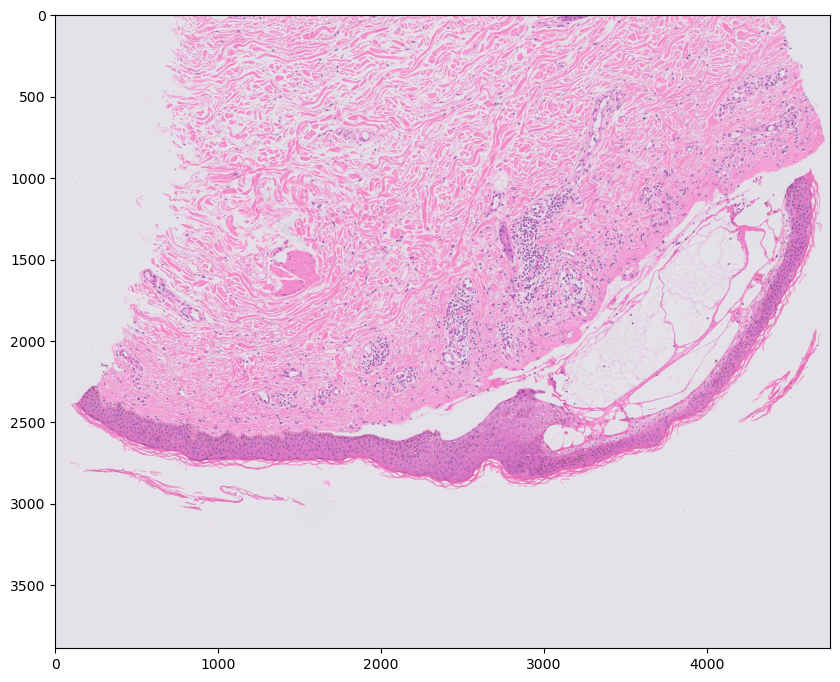

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

### Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

- sam_model_registry : segment_anything > build_sam.py > sam_model_registry class <br><br/>
    - model_type : vit_h, vit_l, vit_b (각 타입마다 image encoder의 patameter가 다름) <br><br/>
    Three model versions of the model are available with different backbone sizes. These models can be instantiated by running<br><br/>
    모델(pth파일)은 github README 'Model checkpoints'에서 다운


In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

In [10]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

In [11]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an **image embedding** by calling SamPredictor.set_image. SamPredictor remembers this embedding and will use it for subsequent mask prediction.

In [12]:
predictor.set_image(image)

To **select the ROI**, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.<br><br/>

- segment 하기 원하는 좌표 얻기 위해 cv2.selectROIs() 사용 <br><br/>
- 조직 이미지 사이즈 너무 커서 윈도우창 조절 (원본 이미지 비율 유지)
- 원하는 위치 선택 후, enter 클릭 -> 새로운 위치 선택 

In [13]:
image.shape

(3888, 4760, 3)

In [14]:
# 원하는 위치 좌표 추출
# 윈도우 창 크기를 더 작게 하려면 ratio 조절

raw_h, raw_w, _ = image.shape

ratio = 5
cv2.namedWindow("coordinate", cv2.WINDOW_NORMAL)
cv2.resizeWindow(winname="coordinate", width=round(raw_w/ratio), height=round(raw_h/ratio))  

rects = cv2.selectROIs("coordinate", image, True, False)   # rects = x, y, w, h
print(rects)

cv2.destroyAllWindows()

[[4480 1064  190  150]
 [4260 1754  165  130]
 [2710 2554  270  195]
 [2215 2654  135  130]
 [ 515 2514  130  120]]


In [15]:
points = []

for rect in rects:
    x, y, w, h = rect
    x_point = round(x+w/2)
    y_point = round(y+h/2)
    point = [x_point, y_point]
    points.append(point)
    
print(points)

[[4575, 1139], [4342, 1819], [2845, 2652], [2282, 2719], [580, 2574]]


In [16]:
labels = [int(1) for i in range(len(points))]
labels

[1, 1, 1, 1, 1]

In [17]:
# 제외할 위치 좌표

raw_h, raw_w, _ = image.shape

ratio = 5
cv2.namedWindow("coordinate", cv2.WINDOW_NORMAL)
cv2.resizeWindow(winname="coordinate", width=round(raw_w/ratio), height=round(raw_h/ratio))  

except_rects = cv2.selectROIs("coordinate", image, True, False)   # rects = x, y, w, h
print(except_rects)

cv2.destroyAllWindows()

[[4020 1334  250  300]
 [3640 1694  240  270]
 [3325 2084  255  260]
 [2255 1944  190  185]
 [2925 1529  260  185]
 [3695  845  230  149]
 [1020 2224  290  225]]


In [19]:
except_points = []

for except_rect in except_rects:
    x, y, w, h = except_rect
    except_x_point = round(x+w/2)
    except_y_point = round(y+h/2)
    except_point = [except_x_point, except_y_point]
    except_points.append(except_point)
    
print(except_points)

[[4145, 1484], [3760, 1829], [3452, 2214], [2350, 2036], [3055, 1622], [3810, 920], [1165, 2336]]


In [20]:
except_labels = [int(0) for i in range(len(except_points))]
except_labels

[0, 0, 0, 0, 0, 0, 0]

In [21]:
all_points = points + except_points
all_points

[[4575, 1139],
 [4342, 1819],
 [2845, 2652],
 [2282, 2719],
 [580, 2574],
 [4145, 1484],
 [3760, 1829],
 [3452, 2214],
 [2350, 2036],
 [3055, 1622],
 [3810, 920],
 [1165, 2336]]

In [22]:
all_labels = labels + except_labels
all_labels

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [23]:
input_point = np.array(all_points)
input_label = np.array(all_labels)  # 제외할 부분은 0으로!

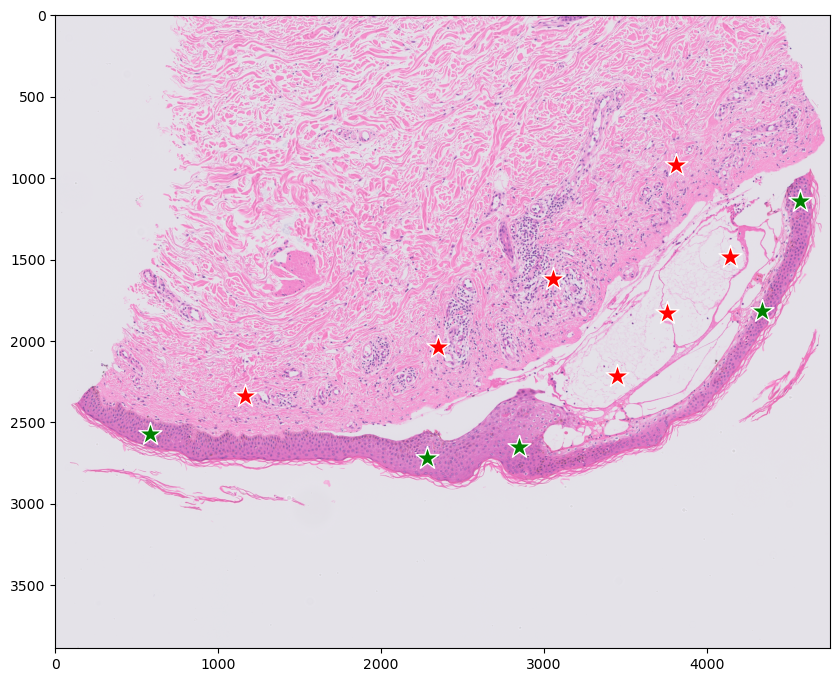

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with SamPredictor.predict. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction. <br><br/>
With **multimask_output=True (the default setting)**, <u>SAM outputs 3 masks</u>, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. <br><br/>
**When False**, <u>it will return a single mask.</u> For ambiguous prompts such as a single point, it is recommended to use multimask_output=True even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

- 원하는 mask를 저장하기 위해서 boolean 값으로 된 mask를 0, 255 숫자로 변환

In [26]:
# mask_input = logits[np.argmax(scores), :, :, :]  # Choose the model's best mask

In [25]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    #mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [26]:
masks.shape  # (number_of_masks) x H x W

(1, 3888, 4760)

In [29]:
masks[0].shape

(3888, 4760)

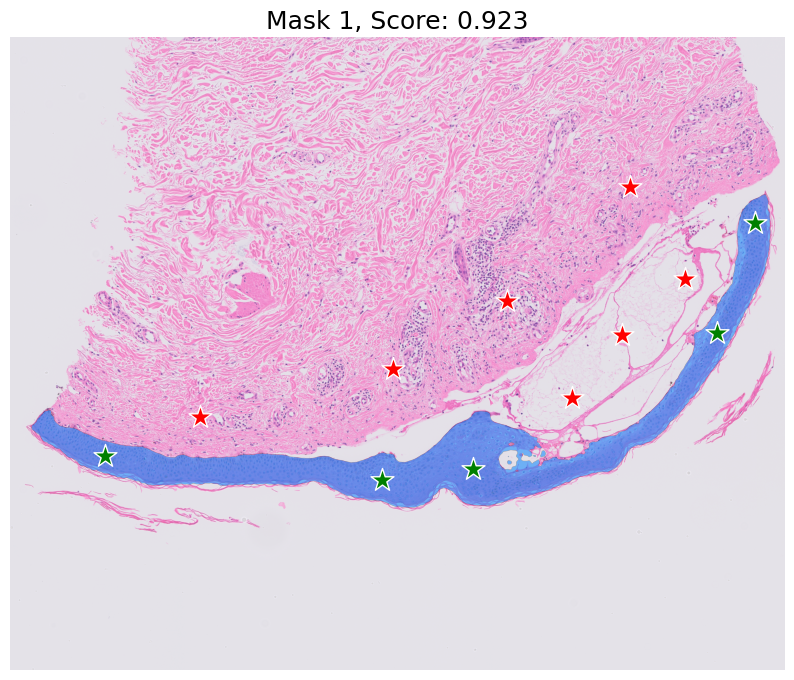

In [27]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [31]:
good_mask = np.where(masks[0], 255, 0).astype(np.uint8)
mask_name = 'epidermis'

cv2.imwrite('BP images/{0}_{1}.png'.format(img_name[:-4], mask_name), good_mask)

True